### Import Dependencies

In [2]:
# Standard Libraries
import os
import random
import copy

# Warnings
import warnings
warnings.filterwarnings('ignore')


# Data Handling and Analysis
import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch: Data Handling
from torch.utils.data import Dataset, DataLoader

# PyTorch: Vision
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

### Only for Google Colab

In [4]:
# Connecting my drive
# from google.colab import drive
# drive.mount('/content/drive')

### Data Distribution

In [6]:
root = './data'
dataset_category = ['train', 'valid', 'test']
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

for dataset in dataset_category:
    print(f"\n{dataset.upper()} IMAGES:")
    for label in class_names:
        root_path = os.path.join(root, dataset, label)
        count = len(os.listdir(root_path))
        print(f"{label}: {count} images")


TRAIN IMAGES:
glioma: 564 images
meningioma: 358 images
no_tumor: 335 images
pituitary: 438 images

VALID IMAGES:
glioma: 161 images
meningioma: 124 images
no_tumor: 99 images
pituitary: 118 images

TEST IMAGES:
glioma: 80 images
meningioma: 63 images
no_tumor: 49 images
pituitary: 54 images


### Visualize the Data Distribution

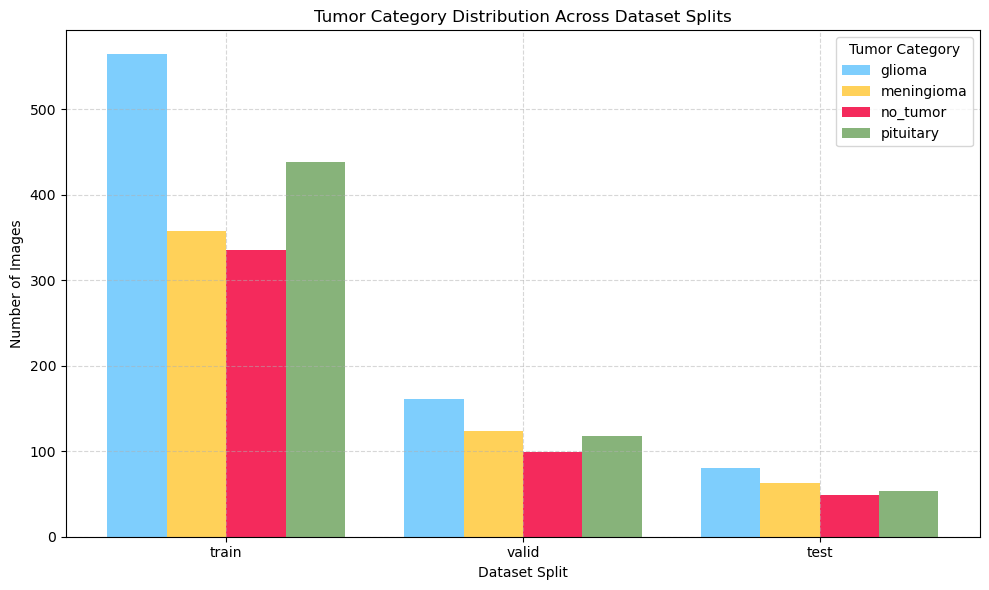

In [8]:
image_counts = {}
for dataset in dataset_category:
    image_counts[dataset] = {}
    for label in class_names:
        root_path = os.path.join(root, dataset, label)
        image_counts[dataset][label] = len(os.listdir(root_path))

dataset_category = list(image_counts.keys())
categories = list(image_counts['train'].keys())
x = np.arange(len(dataset_category))    # x-axis positions
width = 0.2                             # width of each bar

# Extract counts for each category
colors = ['#7ecefd', '#ffd159', '#f42a5c', '#87b37a']
category_counts = {cat: [image_counts[dataset][cat] for dataset in dataset_category] for cat in categories}

# Plotting
plt.figure(figsize=(10, 6))
for i, (cat, color) in enumerate(zip(categories, colors)):
    plt.bar(x + (i - 1.5) * width, category_counts[cat], width, label=cat, color=color)

plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.title('Tumor Category Distribution Across Dataset Splits')
plt.xticks(x, dataset_category)
plt.legend(title='Tumor Category')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Custom PyTorch Dataset for loading brain tumor images from a directory structure

In [10]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Automatically detect class names from the folder names, and sort alphabetically
        self.classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))       # ['glioma', 'meningioma', 'no_tumor', 'pituitary']
        ])
        

        self.image_paths = []                                 # Will store the full paths of image files
        self.labels = []                                      # Will store the corresponding numeric labels for each image

        # Loop through each class directory and collect image paths and class indices
        for idx, label in enumerate(self.classes):            # Assign class index: glioma=0, meningioma=1, no_tumor=2, pituitary=3.
            class_folder = os.path.join(root_dir, label)
            for file in os.listdir(class_folder):
                if file.endswith(('.jpg', '.png', '.jpeg')):  # Filter supported image formats
                    self.image_paths.append(os.path.join(class_folder, file))
                    self.labels.append(idx)                   # Use class index as label

    def __len__(self):
        # Return total number of images in dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Fetch a single image and its label by index
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")         # Ensure image is in RGB format

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
    # Normalize the image with mean and std values from ImageNet,
    # so it matches the input distribution expected by pre-trained models
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Loading the data

In [13]:
#directory
train_dir = './data/train'
valid_dir = './data/valid'

# Load dataset
train_dataset = BrainTumorDataset(train_dir, transform=transform)
valid_dataset = BrainTumorDataset(valid_dir, transform=transform)

# Load data with DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [14]:
# Get a batch
images, labels = next(iter(train_loader))

print(images.shape)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([3, 1, 0, 0, 0, 1, 2, 1, 2, 0, 1, 2, 3, 2, 3, 2, 0, 0, 0, 2, 1, 0, 0, 0,
        3, 1, 3, 0, 1, 1, 2, 0])


### Visualize the N Number of Random Images in Each Category

In [16]:
def plot_random_by_class(dataset, class_names, num=5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    import numpy as np

    def unnormalize(image, mean, std):
        image = image.clone().cpu().numpy()
        image = image.transpose(1, 2, 0)  # [C, H, W] ➜ [H, W, C]
        image = image * std + mean       # Unnormalize
        image = np.clip(image, 0, 1)
        return image

    # Map class index to image indices
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx, label in enumerate(dataset.labels):
        class_to_indices[label].append(idx)

    # Plot `num` images for each class
    for class_idx, class_name in enumerate(class_names):
        indices = random.sample(class_to_indices[class_idx], min(num, len(class_to_indices[class_idx])))

        plt.figure(figsize=(16, 3))
        for i, idx in enumerate(indices):
            image, _ = dataset[idx]
            image = unnormalize(image, mean, std)
            plt.subplot(1, num, i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

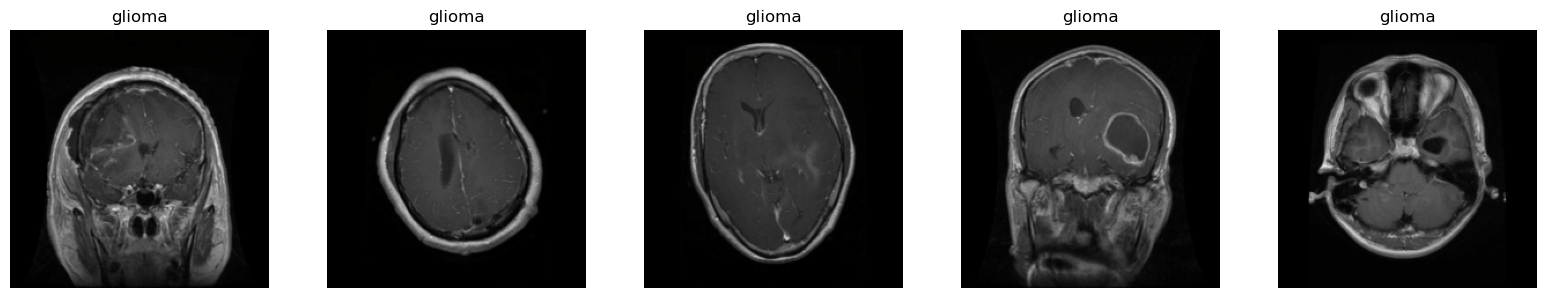

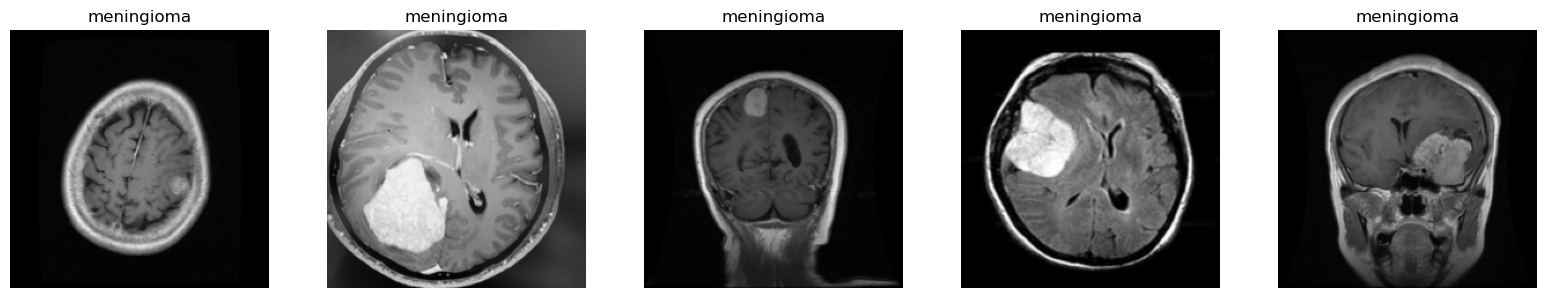

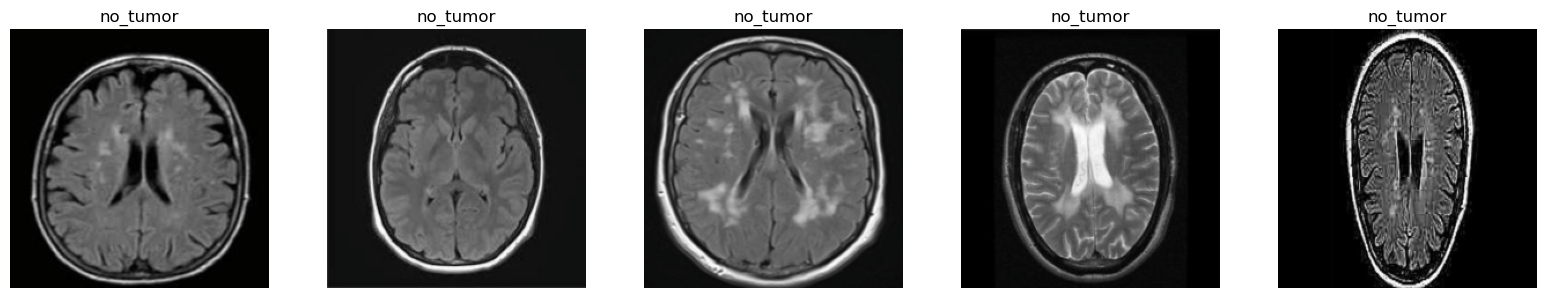

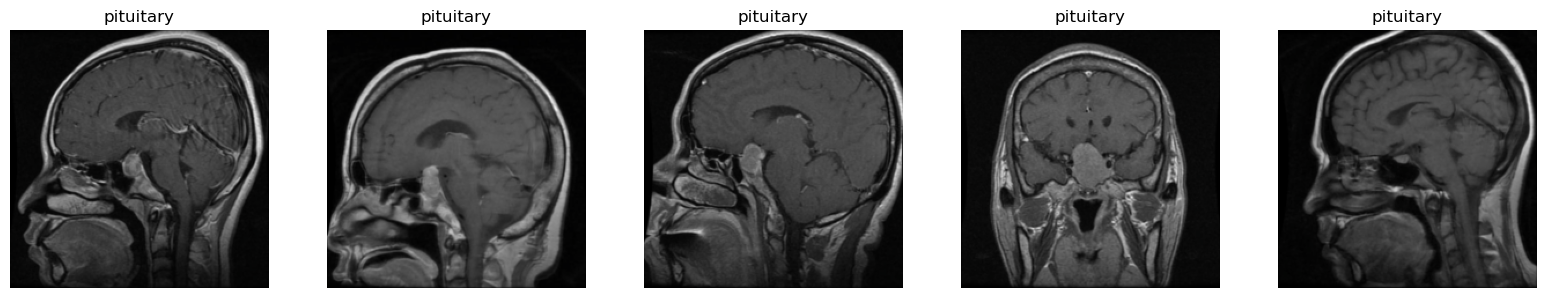

In [17]:
plot_random_by_class(train_dataset, class_names, num=5)

### Define Simple CNN Model

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()  # Initialize the nn.Module superclass

        # First convolutional layer: input = 3 channels (RGB), output = 32 channels, kernel size = 3x3
        self.conv1 = nn.Conv2d(3, 32, 3)

        # Max pooling layer: 2x2 kernel, reduces spatial dimensions by half
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: input = 32, output = 64 channels, kernel size = 3x3
        self.conv2 = nn.Conv2d(32, 64, 3)

        # Placeholder for flattened feature size before fully connected layers
        self._to_linear = None
        self._get_flatten_size()  # Dynamically compute flatten size for FC layer

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 128)   # First dense layer
        self.fc2 = nn.Linear(128, 4)                 # Output layer for 4 classes

    def _get_flatten_size(self):
        # Use a dummy input to calculate output size after conv and pooling layers
        x = torch.randn(1, 3, 224, 224)              # Simulate a single RGB image of size 224x224
        x = self.pool(F.relu(self.conv1(x)))         # Apply conv1 -> ReLU -> pool
        x = self.pool(F.relu(self.conv2(x)))         # Apply conv2 -> ReLU -> pool
        self._to_linear = x.view(1, -1).shape[1]     # Flatten and store the feature size

    def forward(self, x):
        # Forward pass through conv1 + ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))         # Output: [batch, 32, ~111, ~111] → [batch, 32, 74, 74]

        # Forward pass through conv2 + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x)))         # Output: [batch, 64, ~36, ~36]

        # Flatten the feature maps to feed into the fully connected layer
        x = x.view(x.size(0), -1)

        # Pass through the first fully connected layer + ReLU
        x = F.relu(self.fc1(x))

        # Final output layer (no activation here, as loss function like CrossEntropy expects raw logits)
        x = self.fc2(x)
        return x

### Train the Model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
model = SimpleCNN().to(device)

In [23]:
model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=186624, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
def train(model, dataloader, optimizer, criterion):
    model.train()  # Set the model to training mode (important for layers like Dropout, BatchNorm)

    running_loss, correct, total = 0.0, 0, 0  # Initialize trackers

    for inputs, labels in dataloader:
        # Move data to GPU (if available)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()              # Clear previous gradients
        outputs = model(inputs)            # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                    # Backpropagation (calculate gradients)
        optimizer.step()                   # Update model weights

        # Accumulate total loss scaled by batch size
        running_loss += loss.item() * inputs.size(0)

        # Get predicted class labels
        _, preds = torch.max(outputs, 1)

        # Count correct predictions
        correct += (preds == labels).sum().item()
        total += labels.size(0)  # Keep track of number of samples

    # Compute average loss and accuracy for the epoch
    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

# Train model with N epochs
for epoch in range(5):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

Epoch 1 | Train Loss: 1.6862 | Train Acc: 0.6507
Epoch 2 | Train Loss: 0.3671 | Train Acc: 0.8655
Epoch 3 | Train Loss: 0.1843 | Train Acc: 0.9416
Epoch 4 | Train Loss: 0.0910 | Train Acc: 0.9729
Epoch 5 | Train Loss: 0.0262 | Train Acc: 0.9947


### Validate and Plot(confusion matrix) the Simple CNN Model

In [27]:
def evaluate(model, dataloader):
    model.eval()                                   # Set model to evaluation mode (disables dropout, batchnorm updates)

    all_preds, all_labels = [], []                 # Lists to store predictions and true labels

    with torch.no_grad():                          # Disable gradient computation (saves memory & speeds up inference)
        for inputs, labels in dataloader:
            inputs = inputs.to(device)             # Move inputs to GPU/CPU
            outputs = model(inputs)                # Forward pass to get logits

            _, preds = torch.max(outputs, 1)       # Get predicted class (index of highest score)
            all_preds.extend(preds.cpu().numpy())  # Move to CPU & convert to NumPy list
            all_labels.extend(labels.numpy())      # True labels (already on CPU)

    return all_labels, all_preds                   # Return all predictions and ground-truth labels

In [28]:
labels_true, labels_pred = evaluate(model, valid_loader)  # Get predictions on validation set

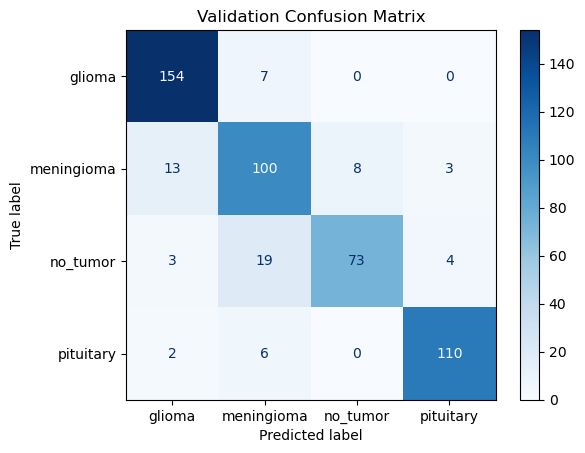

In [29]:
# Compute confusion matrix
cm = confusion_matrix(labels_true, labels_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix with a blue color map
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

In [30]:
torch.save(model.state_dict(), 'simplecnn_best.pt')

### Define Improved CNN Model

In [32]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()        # Initialize parent nn.Module class

        # First convolutional layer: 3 input channels (RGB), 32 output channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)              # Batch normalization to stabilize learning
        self.pool = nn.MaxPool2d(2, 2)             # Max pooling with 2x2 window to downsample

        # Second convolutional layer: 32 input -> 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third convolutional layer: 64 input -> 128 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout layer for regularization (reduce overfitting)
        self.dropout = nn.Dropout(0.5)

        # Placeholder for flattened size after conv layers (computed dynamically)
        self._to_linear = None
        self._get_flatten_size()                    # Call helper function to compute this size

        # Fully connected (dense) layers
        self.fc1 = nn.Linear(self._to_linear, 128)  # First dense layer
        self.fc2 = nn.Linear(128, 4)                # Final layer: 4 output classes (e.g., tumor types)

    def _get_flatten_size(self):
        # Use a dummy input to automatically calculate the size of the flattened feature map
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)         # Fake image with shape (batch=1, C=3, H=224, W=224)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(1, -1).shape[1]  # Flatten and get size for fc1

    def forward(self, x):
        # Forward pass through conv -> BN -> ReLU -> pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten output for fully connected layers
        x = x.view(x.size(0), -1)

        # Pass through fc1 with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))

        # Final layer (logits output for classification)
        x = self.fc2(x)
        return x

In [33]:
model = ImprovedCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
model

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

### Train the Improved CNN Model

In [36]:
def train(model, dataloader, optimizer, criterion):
    model.train()                                   # Set model to training mode (enables dropout, batchnorm updates)
    running_loss, correct = 0.0, 0                  # Initialize accumulators for loss and accuracy
    total = 0                                       # Total number of samples processed

    # Loop over mini-batches
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU or CPU

        optimizer.zero_grad()                             # Clear previous gradients
        outputs = model(images)                           # Forward pass: compute model predictions

        loss = criterion(outputs, labels)                 # Compute loss between predictions and true labels
        loss.backward()                                   # Backpropagation: compute gradients
        optimizer.step()                                  # Update model weights

        running_loss += loss.item() * images.size(0)      # Accumulate total loss (scaled by batch size)
        _, preds = torch.max(outputs, 1)                  # Get predicted class (index with max logit)
        correct += (preds == labels).sum().item()         # Count correct predictions
        total += labels.size(0)                           # Track total number of samples

    # Return average loss and accuracy over all batches
    return running_loss / total, correct / total


# Train for 10 epochs
for epoch in range(10):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)                # One epoch of training
    print(f"Epoch {epoch+1}    |    Loss: {train_loss:.4f}    |    Acc: {train_acc:.4f}")   # Output metrics

Epoch 1    |    Loss: 3.9699    |    Acc: 0.5540
Epoch 2    |    Loss: 0.8730    |    Acc: 0.6041
Epoch 3    |    Loss: 0.8267    |    Acc: 0.6313
Epoch 4    |    Loss: 0.8106    |    Acc: 0.6726
Epoch 5    |    Loss: 0.7452    |    Acc: 0.7109
Epoch 6    |    Loss: 0.7090    |    Acc: 0.6903
Epoch 7    |    Loss: 0.6808    |    Acc: 0.7103
Epoch 8    |    Loss: 0.6165    |    Acc: 0.7386
Epoch 9    |    Loss: 0.6049    |    Acc: 0.7316
Epoch 10    |    Loss: 0.5492    |    Acc: 0.7569


### Validate and Plot the Improved CNN Model

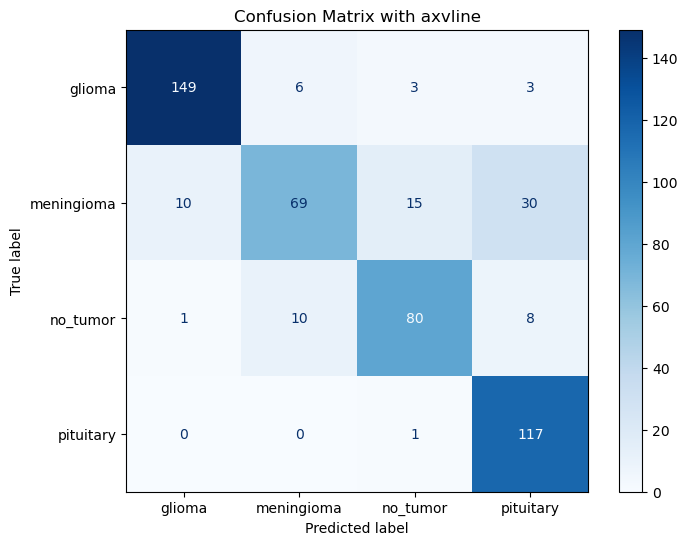

In [38]:
def validate_and_plot(model, valid_loader, class_names):
    model.eval()       # Set the model to evaluation mode
    all_preds, all_labels = [], []

    # Disable gradient calculation for validation to save memory and compute
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)

            # Forward pass only (no backpropagation)
            outputs = model(images)

            # Get the predicted class with the highest score
            _, preds = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Compute and plot the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix with axvline")
    plt.show()

# Validate after training
validate_and_plot(model, valid_loader, ['glioma', 'meningioma', 'no_tumor', 'pituitary'])

In [39]:
torch.save(model.state_dict(), 'improvedcnn_best.pt')

### Function to Get Pretrained Model

In [41]:
def prepare_model(model_name, num_classes):
    # Select and customize the model architecture 
    if model_name == 'resnet50':
        # Load pretrained ResNet50 with default ImageNet weights
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Replace the final fully connected layer to match number of output classes
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == 'mobilenet_v2':
        # Load pretrained MobileNetV2 with default ImageNet weights
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

        # Replace the last layer of the classifier to match the number of classes
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == 'efficientnet_b0':
        # Load pretrained EfficientNet-B0 with default ImageNet weights
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Modify the classifier's last layer to match the number of output classes
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        # Raise an error if the model name is not supported
        raise ValueError("Unsupported model")

    # Move the model to the designated device (GPU or CPU)
    model = model.to(device)

    # Define loss function: CrossEntropyLoss is suitable for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Define optimizer with Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Return the model, loss function, and optimizer
    return model, criterion, optimizer

### Train & Validation Function

In [43]:
def train_validate(model, criterion, optimizer, train_loader, valid_loader, model_name, num_epochs=5):
    train_losses, val_losses = [], []                # Store losses to plot later
    best_f1 = 0.0                                    # Track best validation F1 score to save best model
    class_names = train_loader.dataset.classes       # Class labels from dataset

    for epoch in range(num_epochs):
        model.train()                                # Set model to training mode
        running_loss, correct, total = 0, 0, 0       # Reset counters for training loss and accuracy

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)    # Move data to GPU/CPU
            optimizer.zero_grad()                                    # Clear gradients from previous step
            
            outputs = model(images)                                  # Forward pass
            loss = criterion(outputs, labels)                        # Compute loss
            
            loss.backward()                                          # Backpropagation
            optimizer.step()                                         # Update weights

            running_loss += loss.item()                              # Accumulate total loss
            _, preds = torch.max(outputs, 1)                         # Get predicted classes
            correct += (preds == labels).sum().item()                # Count correct predictions
            total += labels.size(0)                                  # Total number of samples

        epoch_loss = running_loss / len(train_loader)                # Average training loss
        epoch_acc = correct / total                                  # Training accuracy
        train_losses.append(epoch_loss)                              # Save for plotting

        # Validation loop
        model.eval()                                                 # Set model to evaluation mode (disables dropout, batchnorm freezes)
        val_loss, y_true, y_pred = 0, [], []                         # Reset validation metrics

        with torch.no_grad():                                        # Disable gradient calculation for efficiency
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)                              # Forward pass
                loss = criterion(outputs, labels)                    # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)                     # Get predictions
                y_true.extend(labels.cpu().numpy())                  # Collect true labels
                y_pred.extend(preds.cpu().numpy())                   # Collect predicted labels

        avg_val_loss = val_loss / len(valid_loader)                  # Average validation loss
        val_losses.append(avg_val_loss)                              # Save for plotting

        val_f1 = f1_score(y_true, y_pred, average='macro')           # Macro-average F1 score

        # Print epoch summary
        print(f"\nEpoch {epoch+1} --> Train Acc: {epoch_acc:.4f}   |   F1 score: {val_f1:.4f}")

        # Save the best model based on F1 score
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f'{model_name}_best.pt')
            best_y_true = y_true
            best_y_pred = y_pred

    # Plot Loss Curve
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"{model_name.upper()} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(best_y_true, best_y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name.upper()} - Confusion Matrix")
    plt.show()

    # Classification Report
    print(f"\n{model_name.upper()} - Classification Report:\n")
    print(classification_report(best_y_true, best_y_pred, target_names=class_names))

    return best_f1                                   # Return the best F1 score


Running model: RESNET50

Epoch 1 --> Train Acc: 0.8395   |   F1 score: 0.8596

Epoch 2 --> Train Acc: 0.9652   |   F1 score: 0.9449

Epoch 3 --> Train Acc: 0.9912   |   F1 score: 0.9427

Epoch 4 --> Train Acc: 0.9953   |   F1 score: 0.9645

Epoch 5 --> Train Acc: 0.9953   |   F1 score: 0.9498


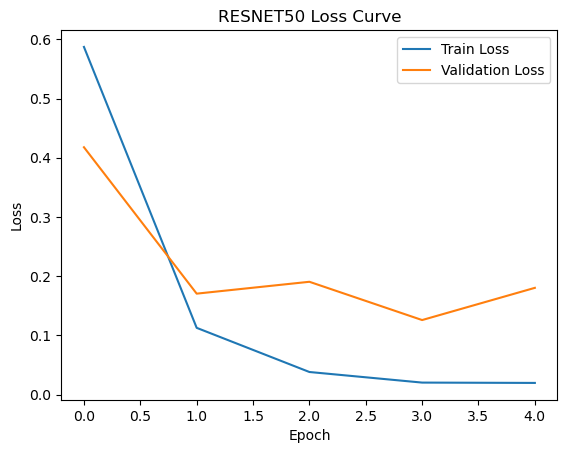

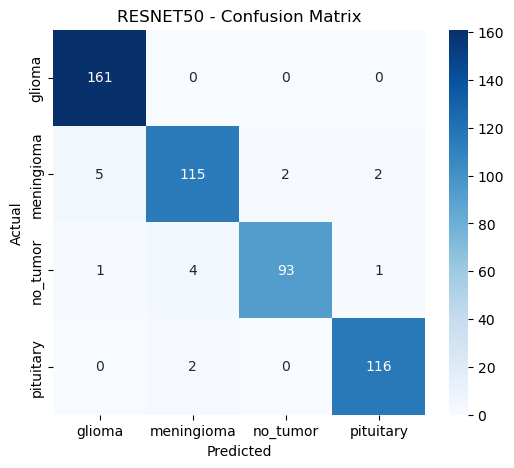


RESNET50 - Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      1.00      0.98       161
  meningioma       0.95      0.93      0.94       124
    no_tumor       0.98      0.94      0.96        99
   pituitary       0.97      0.98      0.98       118

    accuracy                           0.97       502
   macro avg       0.97      0.96      0.96       502
weighted avg       0.97      0.97      0.97       502


Running model: MOBILENET_V2

Epoch 1 --> Train Acc: 0.7351   |   F1 score: 0.8499

Epoch 2 --> Train Acc: 0.9086   |   F1 score: 0.9277

Epoch 3 --> Train Acc: 0.9611   |   F1 score: 0.9376

Epoch 4 --> Train Acc: 0.9823   |   F1 score: 0.9368

Epoch 5 --> Train Acc: 0.9953   |   F1 score: 0.9451


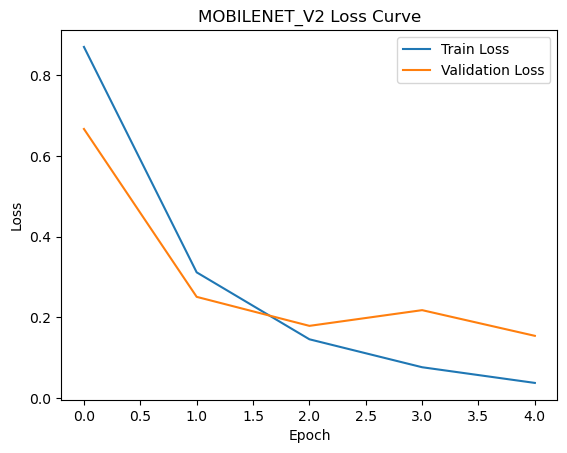

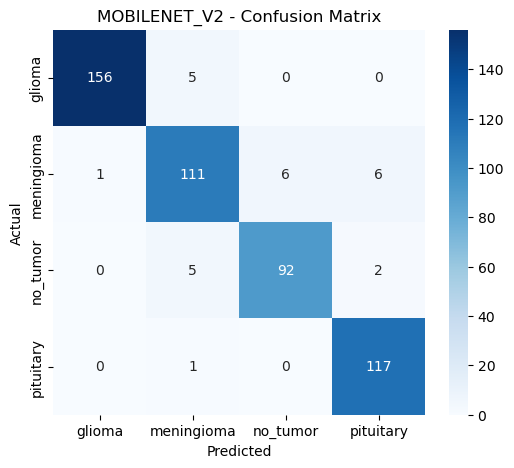


MOBILENET_V2 - Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       161
  meningioma       0.91      0.90      0.90       124
    no_tumor       0.94      0.93      0.93        99
   pituitary       0.94      0.99      0.96       118

    accuracy                           0.95       502
   macro avg       0.94      0.95      0.95       502
weighted avg       0.95      0.95      0.95       502


Running model: EFFICIENTNET_B0

Epoch 1 --> Train Acc: 0.7634   |   F1 score: 0.8721

Epoch 2 --> Train Acc: 0.9298   |   F1 score: 0.9322

Epoch 3 --> Train Acc: 0.9646   |   F1 score: 0.9473

Epoch 4 --> Train Acc: 0.9776   |   F1 score: 0.9524

Epoch 5 --> Train Acc: 0.9858   |   F1 score: 0.9593


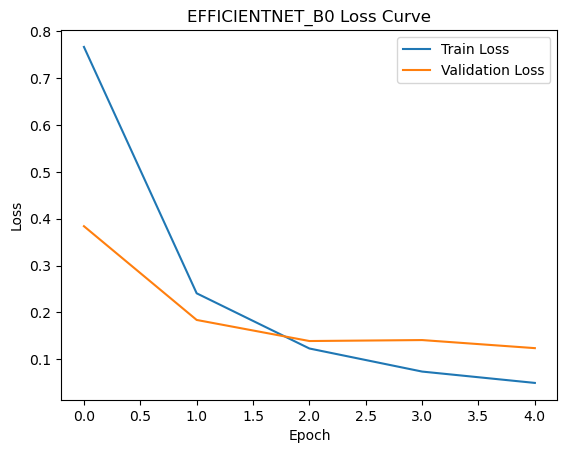

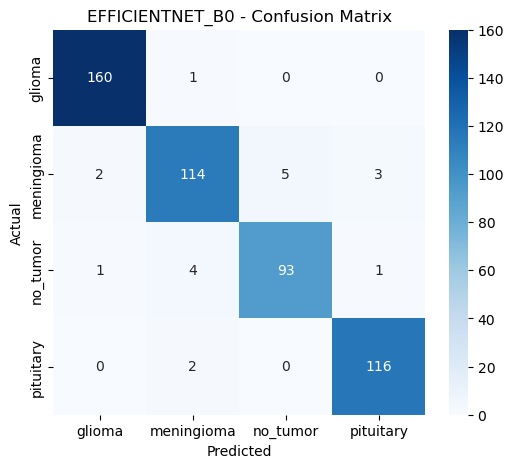


EFFICIENTNET_B0 - Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       161
  meningioma       0.94      0.92      0.93       124
    no_tumor       0.95      0.94      0.94        99
   pituitary       0.97      0.98      0.97       118

    accuracy                           0.96       502
   macro avg       0.96      0.96      0.96       502
weighted avg       0.96      0.96      0.96       502



In [44]:
# List of model names to be tested
model_list = ['resnet50', 'mobilenet_v2', 'efficientnet_b0']

# Dictionary to store F1 scores for each model
results = {}

# Iterate through each model in the list
for model_name in model_list:
    print(f"\nRunning model: {model_name.upper()}")        # Display which model is being trained

    # Prepare model, loss function, and optimizer
    model, criterion, optimizer = prepare_model(model_name, num_classes=len(class_names))

    # Train and validate the model
    f1 = train_validate(model, criterion, optimizer, train_loader, valid_loader, model_name)
    
    # Save the F1 score in results dictionary
    results[model_name] = f1

In [45]:
# Step 6: Display Best Model
best_model = max(results, key=results.get)
print("\nModel Comparison:")
for model_name, f1 in results.items():
    print(f"{model_name}: F1 Score = {f1:.4f}")

print(f"\nBest Model: {best_model} with F1 Score = {results[best_model]:.4f}")


Model Comparison:
resnet50: F1 Score = 0.9645
mobilenet_v2: F1 Score = 0.9451
efficientnet_b0: F1 Score = 0.9593

Best Model: resnet50 with F1 Score = 0.9645
